In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf #needed for models in this script
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
pd.set_option('html', True) #see the dataframe in a more user friendly manner
%matplotlib inline

## Get Data

In [3]:
train = pd.read_csv('san_fran_training.csv')
test = pd.read_csv('san_fran_test.csv')

In [4]:
train.head(2)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [5]:
test.head(2)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432


In [6]:
print 'training length:', len(train)
print 'testing length:', len(test)

training length: 878049
testing length: 884262


In [7]:
train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [8]:
#change date datatype from object to datetime:
train['Dates'] = train['Dates'].astype('datetime64[ns]')

In [9]:
train.dtypes

Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
dtype: object

<b>Visualize and Explore Data:</b>

In [10]:
train.DayOfWeek.value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
dtype: int64

In [11]:
print train.Category.value_counts()
print ''
print 'Number of Categories:', train.Category.value_counts().count()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [12]:
print train.Descript.value_counts()
print ''
print 'Number of Descriptions:', train.Descript.value_counts().count()

GRAND THEFT FROM LOCKED AUTO                                60022
LOST PROPERTY                                               31729
BATTERY                                                     27441
STOLEN AUTOMOBILE                                           26897
DRIVERS LICENSE, SUSPENDED OR REVOKED                       26839
WARRANT ARREST                                              23754
SUSPICIOUS OCCURRENCE                                       21891
AIDED CASE, MENTAL DISTURBED                                21497
PETTY THEFT FROM LOCKED AUTO                                19771
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES                   17789
TRAFFIC VIOLATION                                           16471
PETTY THEFT OF PROPERTY                                     16196
MALICIOUS MISCHIEF, VANDALISM                               15957
THREATS AGAINST LIFE                                        14716
FOUND PROPERTY                                              12146
ENROUTE TO

In [13]:
train.PdDistrict.value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
dtype: int64

In [14]:
train.Resolution.value_counts()

NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
dtype: int64

In [15]:
print train.Address.value_counts()
print ''
print 'Number of Categories:', train.Address.value_counts().count()

800 Block of BRYANT ST             26533
800 Block of MARKET ST              6581
2000 Block of MISSION ST            5097
1000 Block of POTRERO AV            4063
900 Block of MARKET ST              3251
0 Block of TURK ST                  3228
0 Block of 6TH ST                   2884
300 Block of ELLIS ST               2703
400 Block of ELLIS ST               2590
16TH ST / MISSION ST                2504
1000 Block of MARKET ST             2489
1100 Block of MARKET ST             2319
2000 Block of MARKET ST             2168
100 Block of OFARRELL ST            2140
700 Block of MARKET ST              2081
3200 Block of 20TH AV               2035
100 Block of 6TH ST                 1887
500 Block of JOHNFKENNEDY DR        1824
TURK ST / TAYLOR ST                 1810
200 Block of TURK ST                1800
0 Block of PHELAN AV                1791
0 Block of UNITEDNATIONS PZ         1789
0 Block of POWELL ST                1717
100 Block of EDDY ST                1681
1400 Block of PH

In [32]:
#look at the lat and long co-ordinates:
print max(train.X)
print min(train.X)
print max(train.Y)
print min(train.Y)

-120.5
-122.513642064
90.0
37.7078790224


Latitude of 90.0 and longtitude of -120.5 don't make sense. This pair is also plotted together - we can go ahead and drop these data points:

In [35]:
print len(train[train.Y == 90.0])
print len(train[train.X == -120.5])
print len(train)
print len(train) - 67

67
67
878049
877982


In [36]:
train = train[train.X != -120.5]
train = train[train.Y != -90]
len(train)

877982

In [37]:
print max(train.X)
print min(train.X)
print max(train.Y)
print min(train.Y)

-122.364937494
-122.513642064
37.8199754923
37.7078790224


In [50]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

def column_scatter(dataframe,column1,column2,color_column):

    #scatterplot:
    plt.figure(figsize=(13, 9))

    #data:
    features = dataframe[[column1, column2]]
    color_feature = dataframe[color_column]

    #Get unique names of color_feature
    uniq = list(set(color_feature))

    # Set the color map to match the number of species
    z = range(1,len(uniq))
    hot = plt.get_cmap('jet')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    # Plot each species
    for i in range(len(uniq)):
        indx = color_feature == uniq[i]
        plt.scatter(features.ix[:, 0][indx], features.ix[:, 1][indx], s=2 , alpha=0.5, color=scalarMap.to_rgba(i), label=uniq[i])
        #s=30; size of dots in the graph
    
    #set limits for the axis:
    x_min, x_max = features.ix[:, 0].min() + .001, features.ix[:, 0].max() + .001 #min/max for sepal length
    y_min, y_max = features.ix[:, 1].min() - .001, features.ix[:, 1].max() + .001 #min/max for sepal width

    #set labels:
    plt.xlabel(column1, fontsize = 12)
    plt.ylabel(column2, fontsize = 12)
    plt.title('Color based on ' + color_column + ' for ' + column1 + ' vs. ' + column2, fontsize=14)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.legend(title='Cluster', loc='best')
    plt.grid()
    plt.show

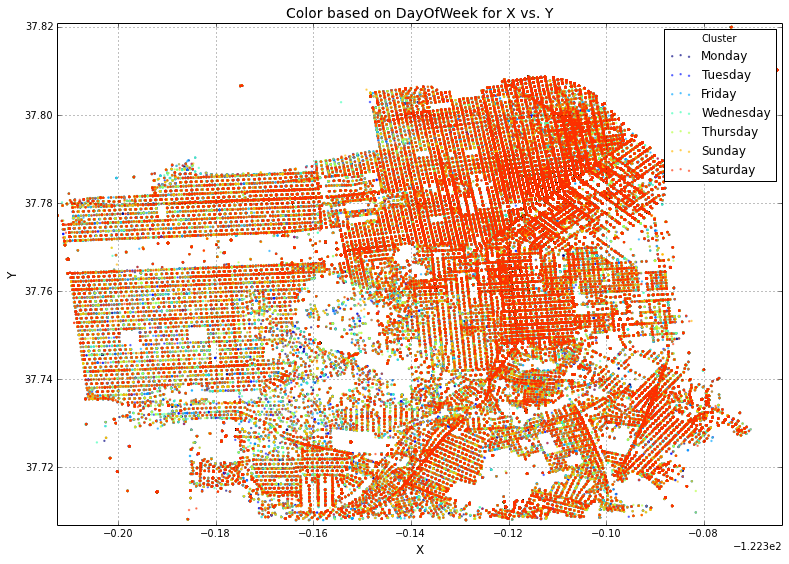

In [51]:
column_scatter(train,'X','Y','DayOfWeek')

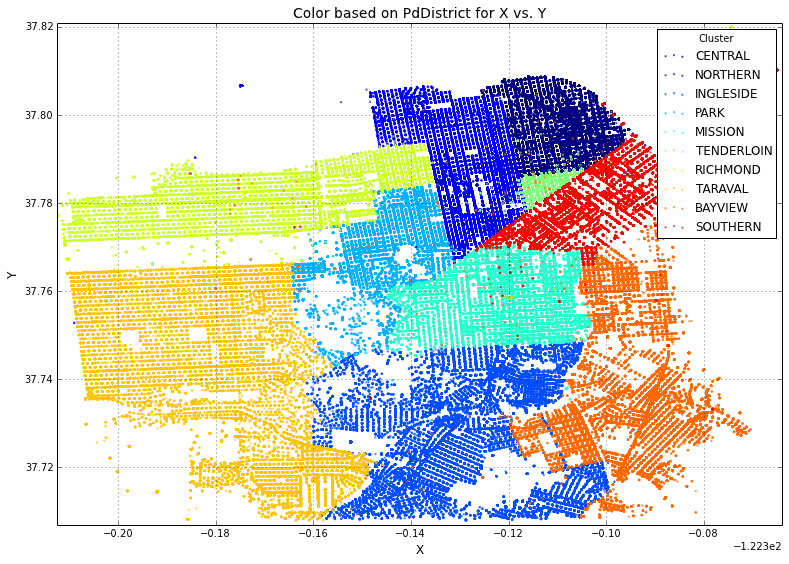

In [52]:
column_scatter(train,'X','Y','PdDistrict')